# 브런치 사용자를 위한 작가 및 글 추천

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud
from PIL import Image
import glob
from itertools import chain
from collections import Counter
from typing import Optional, List, Dict

from fontlib import set_font_family
set_font_family()

import os
os.chdir('data')

## Load Data

In [2]:
magazine = pd.read_json('magazine.json', lines=True)
print(magazine.shape)
magazine.head()

(27967, 2)


,magazine_tag_list,id
0,"[브런치북, 육아일기, 대화법, 들려주고픈이야기]",38842
1,"[tea, food]",11540
2,[food],11541
3,"[브런치북, 일상, 시, 사람]",11546
4,"[감성에세이, 노래, 음악에세이]",11544


In [3]:
metadata = pd.read_json('metadata.json', lines=True)
print(metadata.shape)
metadata.head()

(643104, 9)


,magazine_id,user_id,title,keyword_list,display_url,sub_title,reg_ts,article_id,id
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34


In [4]:
user_df = pd.read_json('users.json', lines=True)
print(user_df.shape)
user_df.head()

(310758, 3)


,keyword_list,following_list,id
0,[],"[@perytail, @brunch]",#901985d8bc4c481805c4a4f911814c4a
1,[],"[@holidaymemories, @wadiz, @sciforus, @dailydu...",#1fd89e9dcfa64b45020d9eaca54e0eed
2,[],"[@commerceguy, @sunsutu, @kakao-it, @joohoonja...",#1d94baaea71a831e1f33e1c6bd126ed5
3,[],"[@amberjeon48, @forsy20, @nemotokki, @hawann, ...",#04641c01892b12dc018b1410e4928c0d
4,[],"[@dwcha7342, @iammento, @kakao-it, @dkam, @ant...",#65bcaff862aadff877e461f54187ab62


In [5]:
user_keyword = pd.read_excel('user_keyword.xlsx')
print(user_keyword.shape)
user_keyword.head()

(100, 2)


,user_id,keyword_list
0,#00001ba6ca8d87d2fc34d626ba9cfe6f,"['사랑', '성공', '인생', '브런치', '작가', '글쓰기', '해외취업',..."
1,#0000e87158c1426d6ffb72cebac6cb64,"['브런치', '가해자', '여성혐오', '페미니스트']"
2,#0000eea6d339abfd02ed590bc451fc63,"['인간관계', '해외생활', '회사']"
3,#0000fdba8f35c76eacab74c5c6bc7f1a,"['도쿄', '여행', '그림에세이', '도쿄', '여행', '그림에세이', '운동..."
4,#000127ad0f1981cae1292efdb228f0e9,"['사랑', '결혼', '결혼생활', '사랑', '결혼', '결혼생활', '연애',..."


In [ ]:
read_files = sorted(glob.glob('read/*'))
print(len(read_files))
print(read_files[1], len(pd.read_csv(read_files[1], header=None)))
print(pd.read_csv(read_files[1], header=None).loc[1].tolist())

3624
read/2018100101_2018100102 708
['#a574678a889dfb7a8b3e2f5ac9e34abf @onthepaper_53 @onthepaper_52 @onthepaper_54 @onthepaper_53 @icebergw_130 @icebergw_130 ']


In [ ]:
read_data = list()
for f in read_files:
    file_df = pd.read_csv(f, header=None, names=['raw'])
    file_df['date'] = os.path.basename(f)[:8]
    file_df['hour'] = os.path.basename(f)[8:10]
    file_df['user_id'] = file_df['raw'].str.split().str[0]
    file_df['article_id'] = file_df['raw'].str.split().str[1:]
    read_data.append(file_df.drop(['raw'],axis=1).explode('article_id'))
read_df = pd.concat(read_data)
print(read_df.shape)
read_df.head()

(22110706, 4)


,date,hour,user_id,article_id
0,20181001,00,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@miamiyoung_31
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@banksalad_49
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@rlfrjsdn_95
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@readme999_140


In [ ]:
print("전체 데이터 건수:", len(read_df))
print("중복을 제외한 데이터 건수:", len(read_df.drop_duplicates(['user_id','article_id'])))
print("전체 독자 수:", len(read_df['user_id'].unique()))
print("전체 읽힌 글 수:", len(read_df['article_id'].unique()))

전체 데이터 건수: 22110706
중복을 제외한 데이터 건수: 12597878
전체 독자 수: 306222
전체 읽힌 글 수: 505841


## EDA

### 작가들이 많이 사용한 키워드 목록

In [ ]:
meta_word_list = sorted(chain.from_iterable(metadata['keyword_list']))
meta_word_dict = Counter(meta_word_list)
meta_word_dict.most_common(5)

[('여행', 33887), ('영화', 27058), ('사랑', 25177), ('에세이', 17629), ('그림일기', 15806)]

In [ ]:
meta_word_cloud = WordCloud(font_path='/System/Library/Fonts/Supplemental/AppleGothic.ttf',
                        max_words=50, width=2000, height=1000,
                        prefer_horizontal= 1.0, background_color='white')
meta_word_cloud.generate_from_frequencies(meta_word_dict)

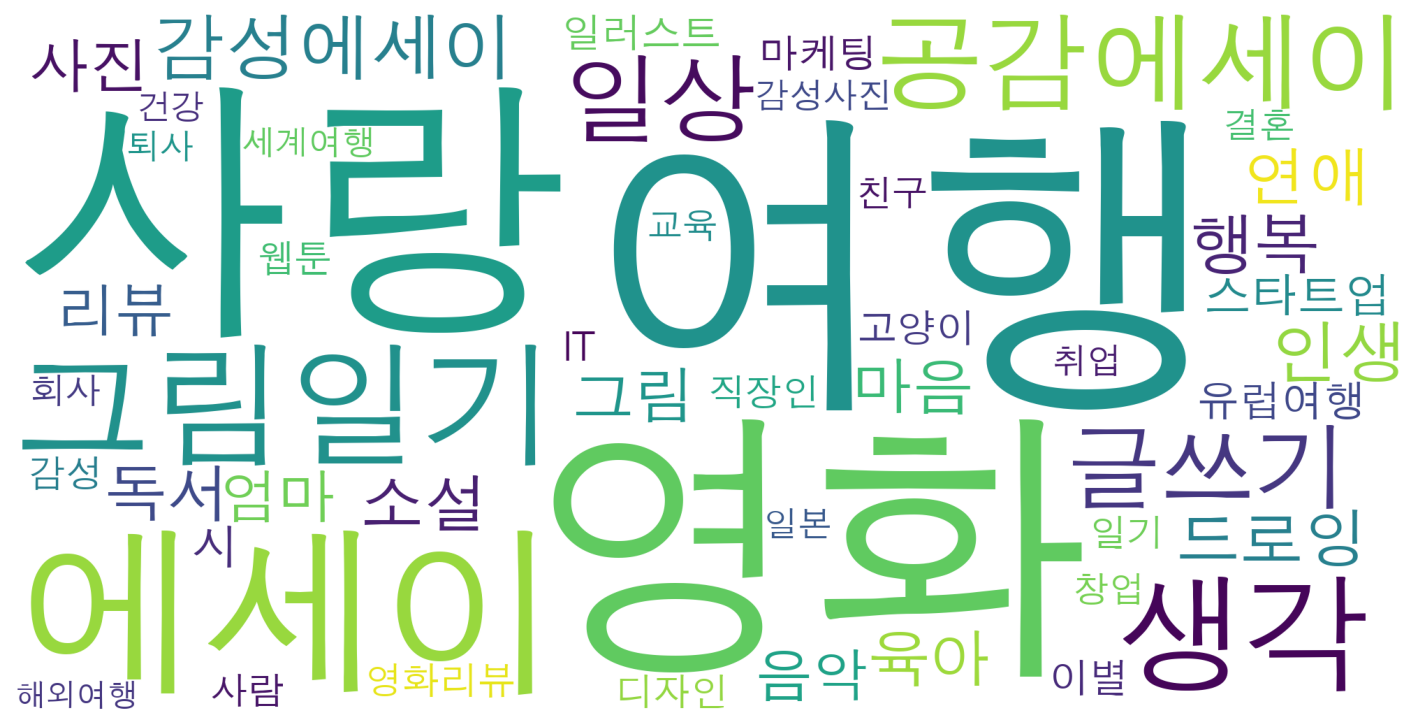

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(meta_word_cloud)
plt.axis('off')
plt.tight_layout()
plt.show()

### 독자들이 팔로우한 작가들의 키워드 목록

In [ ]:
user_keyword['keyword_list'] = user_keyword['keyword_list'].apply(lambda x: eval(x))
user_word_list = sorted(chain.from_iterable(user_keyword['keyword_list']))
user_word_dict = Counter(user_word_list)
user_word_dict.most_common(5)

[('사랑', 160), ('연애', 141), ('공감에세이', 125), ('에세이', 116), ('결혼', 104)]

In [ ]:
user_word_cloud = WordCloud(font_path='/System/Library/Fonts/Supplemental/AppleGothic.ttf',
                        max_words=50, width=2000, height=1000,
                        prefer_horizontal= 1.0, background_color='white')
user_word_cloud.generate_from_frequencies(user_word_dict)

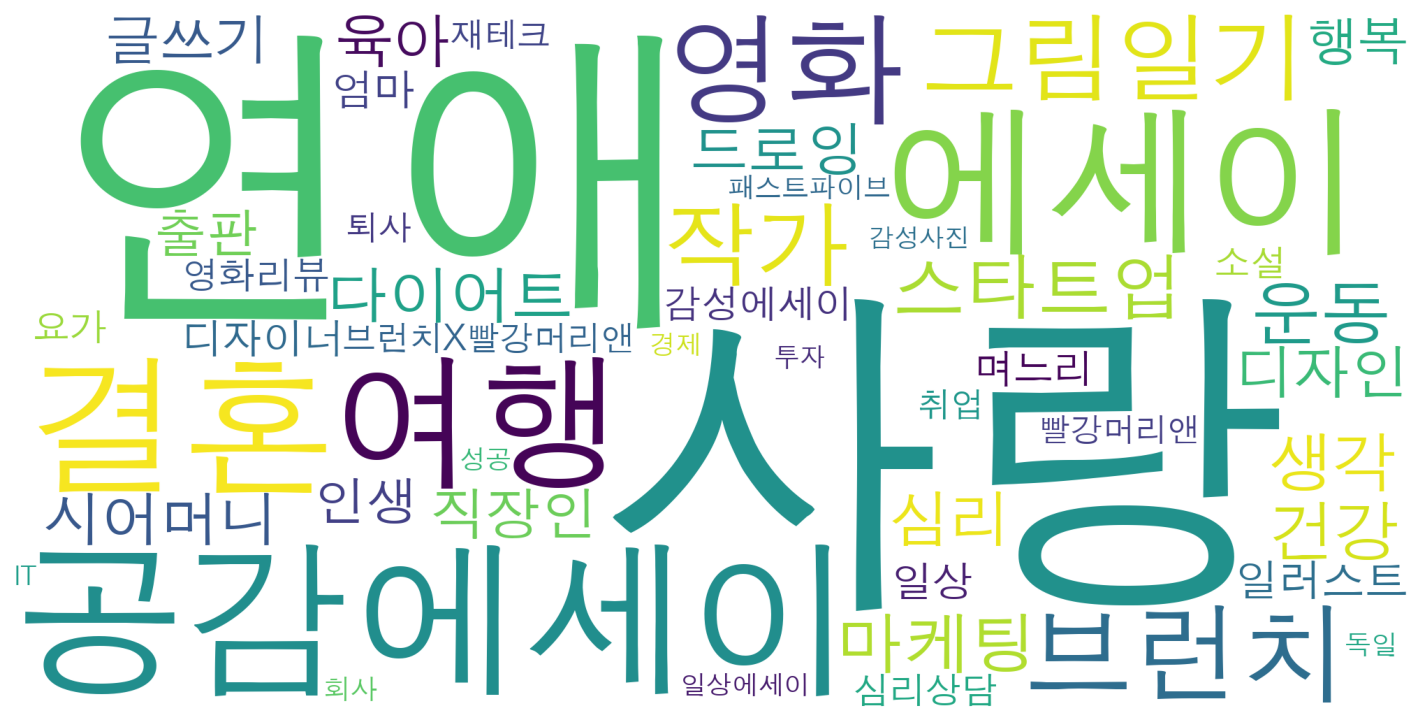

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(user_word_cloud)
plt.axis('off')
plt.tight_layout()
plt.show()

## 데이터 전처리

### 글을 많이 쓴 작가 4000명의 Top20 키워드 목록

In [ ]:
metadata.head()

,magazine_id,user_id,title,keyword_list,display_url,sub_title,reg_ts,article_id,id
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34


In [ ]:
writer_4000 = pd.DataFrame(metadata['user_id'].value_counts().head(4000))
writer_4000.reset_index(inplace=True)
writer_4000.columns = ['writer_id', 'article_num']
writer_4000.head()

,writer_id,article_num
0,@bookfit,4106
1,@wikitree,3192
2,@jordan777,2797
3,@hitchwill,2115
4,@tenbody,1759


In [ ]:
writer_keywords = list()
writer_groups = metadata[['user_id','keyword_list']].groupby('user_id')
for writer in writer_4000['writer_id']:
    keywords = writer_groups.get_group(writer)['keyword_list'].tolist()
    writer_keywords.append(list(chain.from_iterable(keywords)))
writer_4000['keywords'] = writer_keywords
writer_4000.head()

,writer_id,article_num,keywords
0,@bookfit,4106,"[창업, 비즈니스, 문제, 경제, 살림살이, 경제학, 미세먼지, 날씨, 자연, 건축..."
1,@wikitree,3192,"[지휘관, 장교, 청계천, 서울, IT, 번호, 중소기업, 제네시스그룹, 미국해변,..."
2,@jordan777,2797,"[석유에너지, 베네수엘라, 경제, 일자리, 청년실업, 저출산, 플레이, 보이, 적자..."
3,@hitchwill,2115,"[국내여행, 한옥, 청양, 여행, 가을, 코스모스, 감귤농장, 제주감귤, 감귤, 제..."
4,@tenbody,1759,"[운동, 근육, 다이어트, 운동, 뱃살, 다이어트, 운동, 허리, 스트레칭, 스트레..."


In [ ]:
def get_top20_words(word_list: List[str]) -> List[str]:
    word_dict = Counter(word_list).most_common(20)
    return [word for word,count in word_dict]

writer_4000['top20_keywords'] = writer_4000['keywords'].apply(lambda x: get_top20_words(x))
writer_4000.head()

,writer_id,article_num,keywords,top20_keywords
0,@bookfit,4106,"[창업, 비즈니스, 문제, 경제, 살림살이, 경제학, 미세먼지, 날씨, 자연, 건축...","[성공, 행복, 인생, 부동산, 여행, 창업, 사랑, 생각, 인간관계, 교육, 독서..."
1,@wikitree,3192,"[지휘관, 장교, 청계천, 서울, IT, 번호, 중소기업, 제네시스그룹, 미국해변,...","[영화, 뉴스, 연합뉴스, 경찰, 다이어트, 사진, 여행, 박근혜, 맥주, 현대자동..."
2,@jordan777,2797,"[석유에너지, 베네수엘라, 경제, 일자리, 청년실업, 저출산, 플레이, 보이, 적자...","[중국, 미국, 트럼프, 부동산, 주식, 투자, 구글, 아파트, 애플, 일본, 아마..."
3,@hitchwill,2115,"[국내여행, 한옥, 청양, 여행, 가을, 코스모스, 감귤농장, 제주감귤, 감귤, 제...","[국내여행, 영화, 여행, 여행정보, 음식, 사랑, 소설, 일본, 관광, 문경, 브..."
4,@tenbody,1759,"[운동, 근육, 다이어트, 운동, 뱃살, 다이어트, 운동, 허리, 스트레칭, 스트레...","[다이어트, 운동, 건강, 스트레칭, 근육, 뱃살, 요가, 음식, 복근, 하체운동,..."


In [ ]:
writer_4000.to_csv('writer_4000.csv', index=False)

### 사용자가 구독한 작가의 키워드

In [ ]:
user_df.head()

,keyword_list,following_list,id
0,[],"[@perytail, @brunch]",#901985d8bc4c481805c4a4f911814c4a
1,[],"[@holidaymemories, @wadiz, @sciforus, @dailydu...",#1fd89e9dcfa64b45020d9eaca54e0eed
2,[],"[@commerceguy, @sunsutu, @kakao-it, @joohoonja...",#1d94baaea71a831e1f33e1c6bd126ed5
3,[],"[@amberjeon48, @forsy20, @nemotokki, @hawann, ...",#04641c01892b12dc018b1410e4928c0d
4,[],"[@dwcha7342, @iammento, @kakao-it, @dkam, @ant...",#65bcaff862aadff877e461f54187ab62


In [6]:
user_df = user_df[user_df['following_list'].str.len()!=0]

def get_following_writer_keywords(user_id: str) -> List[str]:
    global user_df, writer_4000
    keywords = list()

    for writer_id in user_df['following_list'][user_df['id']==user_id].tolist()[0]:
        keywords += writer_4000['keywords'][writer_4000['writer_id']==writer_id].tolist()

    return list(chain.from_iterable(keywords))

In [ ]:
print('User ID:', user_df['id'][0])
print('Keywords:', get_following_writer_keywords(user_df['id'][0])[:5])

User ID: #901985d8bc4c481805c4a4f911814c4a
Keywords: ['그림일기', '부산외대컴퓨터수리', '현진컴퓨터', '모험', '희극']


## 유사도 분석

### TF-IDF

In [7]:
writer_4000 = pd.read_csv('writer_4000.csv')
writer_4000['keywords'] = writer_4000['keywords'].apply(lambda x: eval(x))
writer_4000['top20_keywords'] = writer_4000['top20_keywords'].apply(lambda x: eval(x))

user_keyword = pd.read_excel('user_keyword.xlsx')
user_keyword['keyword_list'] = user_keyword['keyword_list'].apply(lambda x: eval(x))

In [8]:
corpus = writer_4000['top20_keywords'].str.join(' ').loc[:20]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
cosine_similarity(X, X).argsort()[:,::-1][0]

array([ 0,  5, 17,  7,  9,  3, 10,  8, 16,  4, 15,  1,  6, 14,  2, 19, 13,
       20, 11, 12, 18])

In [9]:
writer_4000.loc[[0,5,17]][['writer_id','top20_keywords']]

,writer_id,top20_keywords
0,@bookfit,"[성공, 행복, 인생, 부동산, 여행, 창업, 사랑, 생각, 인간관계, 교육, 독서..."
5,@ddamimovie,"[영화, 영화리뷰, 사랑, 공감에세이, 여행, 에세이, 영화추천, 책리뷰, 서평, ..."
17,@bookdb,"[소설, 도서, 문학, 신간, 인터뷰, 과학, 여행, 사랑, 애인, 추천도서, 베스..."


### 사용자 키워드 기반으로 유사도가 높은 작가 추천

In [10]:
corpus = writer_4000['keywords'].str.join(' ')
vectorizer = TfidfVectorizer()
writer_vector = vectorizer.fit_transform(corpus)

def get_similar_writers_with_keywords(keywords: List[str], display_num: Optional[int]=3) -> List[str]:
    global writer_4000

    user_vector = vectorizer.transform([' '.join(keywords)])
    similar = cosine_similarity(writer_vector, user_vector)
    similar_indexes = similar.flatten().argsort()[::-1][:display_num]
    return writer_4000['writer_id'][similar_indexes].tolist()

In [11]:
def get_top_words(word_list: List[str], num: Optional[int]=10) -> List[str]:
    word_dict = Counter(word_list).most_common(num)
    return [word for word,count in word_dict]

In [12]:
user_id = user_keyword['user_id'][0]
keywords = user_keyword['keyword_list'][0]
writers = get_similar_writers_with_keywords(keywords)

print('사용자 ID:', user_id)
print('사용자 키워드:', keywords)
print('추천 작가:', writers)
for writer in writers:
    writer_keywords = writer_4000[writer_4000['writer_id']==writer]['keywords'].tolist()[0]
    print(f'{writer} 작가의 키워드:', get_top_words(writer_keywords))

사용자 ID: #00001ba6ca8d87d2fc34d626ba9cfe6f
사용자 키워드: ['사랑', '성공', '인생', '브런치', '작가', '글쓰기', '해외취업', '취직', '싱가포르']
추천 작가: ['@singayoung', '@swimmingstar', '@brunch']
@singayoung 작가의 키워드: ['해외취업', '싱가포르', '취업', '해외', '싱가폴', '면접', '여행', '구직', '친구', '영어']
@swimmingstar 작가의 키워드: ['유럽여행', '해외취업', '싱가포르', '여행', '독일', '터키', '인생', '도서관', '베를린', '트래블라인싱가포르']
@brunch 작가의 키워드: ['브런치', '작가', '인터뷰', '브런치북', '토크콘서트', '출간', '출판', '콜라보레이션', '안내', '에디터']


### 구독한 작가 기반으로 유사도가 높은 작가 추천

In [13]:
corpus = writer_4000['keywords'].str.join(' ')
vectorizer = TfidfVectorizer()
writer_vector = vectorizer.fit_transform(corpus)

def get_similar_writers_with_followings(user_id: str, display_num: Optional[int]=3) -> List[str]:
    global writer_4000

    followings = user_df['following_list'][user_df['id']==user_id].tolist()[0]
    following_keywords = get_following_writer_keywords(user_id)
    following_vector = vectorizer.transform([' '.join(following_keywords)])
    similar = cosine_similarity(writer_vector, following_vector)
    similar_indexes = similar.flatten().argsort()[::-1][:display_num+len(followings)]
    similar_writers = writer_4000['writer_id'][similar_indexes].tolist()
    return [writer for writer in similar_writers if writer not in followings][:display_num]

In [14]:
user_id = user_keyword['user_id'][0]
followings = user_df['following_list'][user_df['id']==user_id].tolist()[0]
writers = get_similar_writers_with_followings(user_id)

print('사용자 ID:', user_id)
print('구독한 작가:', followings)
print('추천 작가:', writers)
for writer in writers:
    writer_keywords = writer_4000[writer_4000['writer_id']==writer]['keywords'].tolist()[0]
    print(f'{writer} 작가의 키워드:', get_top_words(writer_keywords))

사용자 ID: #00001ba6ca8d87d2fc34d626ba9cfe6f
구독한 작가: ['@brunch']
추천 작가: ['@siso-writers', '@thecommaa', '@theee']
@siso-writers 작가의 키워드: ['작가', '글쓰기', '출판', '편집자', '에디터', '출판사', '기획', '원고', '이벤트', '강연']
@thecommaa 작가의 키워드: ['인터뷰', '디지털노마드', '디자인', '마음', '스벅', '셰프', '수필', '패션', '작가', '에세이']
@theee 작가의 키워드: ['인터뷰', '생각', '독서모임', '스타트업', '독서', '인생', '일기', '미국', '선택', '독후감']


### 추천 받은 작가 기반으로 글 추천

In [71]:
def recommend_articles(user_id: str, display_num: Optional[int]=3) -> Dict[str,str]:
    writers = get_similar_writers_with_followings(user_id, display_num)
    recommend_df = metadata[metadata['user_id'].isin(writers)][['title','keyword_list','id']]
    recommend_df = recommend_df[recommend_df['keyword_list'].str.len()>0]
    recommend_df = recommend_df.reset_index().drop('index',axis=1)

    article_keys = recommend_df['keyword_list'].str.join(' ')
    corpus = article_keys
    vectorizer = TfidfVectorizer()
    article_vector = vectorizer.fit_transform(corpus)

    following_keywords = get_following_writer_keywords(user_id)
    following_vector = vectorizer.transform([' '.join(following_keywords)])

    similar = cosine_similarity(article_vector, following_vector)
    similar_indexes = similar.flatten().argsort()[::-1][:display_num]
    return recommend_df[['title','id']].loc[similar_indexes].set_index('title').to_dict()['id']

In [77]:
user_id = user_keyword['user_id'][0]
followings = user_df['following_list'][user_df['id']==user_id].tolist()[0]
articles = recommend_articles(user_id)

print('사용자 ID:', user_id)
print('구독한 작가:', followings)
print('추천 게시글')
for i, (title, id) in enumerate(articles.items(),1):
    print(f'{i}. {title} ({id})')

사용자 ID: #00001ba6ca8d87d2fc34d626ba9cfe6f
구독한 작가: ['@brunch']
추천 게시글
1. <작가를 위한 집필 안내서> 정혜윤 작가와의 인터뷰 (@siso-writers_58)
2. 내가 쓴 원고의 가치를 어떻게 따질 수 있을까? (@siso-writers_8)
3. ‘출간 방향’에 맞지 않는다는 말 (@siso-writers_18)
